<a href="https://colab.research.google.com/github/NethraVK/Customer-Recommender-System/blob/main/Customer_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reading data and checking for missing values
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
url = 'https://archive.ics.uci.edu/static/public/352/data.csv'
data = pd.read_csv(url)
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
print("Total Customer: ", data['CustomerID'].nunique())
print("Total Invoice: ", data['InvoiceNo'].nunique())
print("Total Products: ", data['StockCode'].nunique())
print("Total Country: ", data['Country'].nunique())

Total Customer:  4372
Total Invoice:  25900
Total Products:  4070
Total Country:  38


In [ ]:
# 1. Data Cleaning
#deleting empty cust_id columns
data.dropna(subset=['CustomerID'], inplace=True)
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
#handling duplicates
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


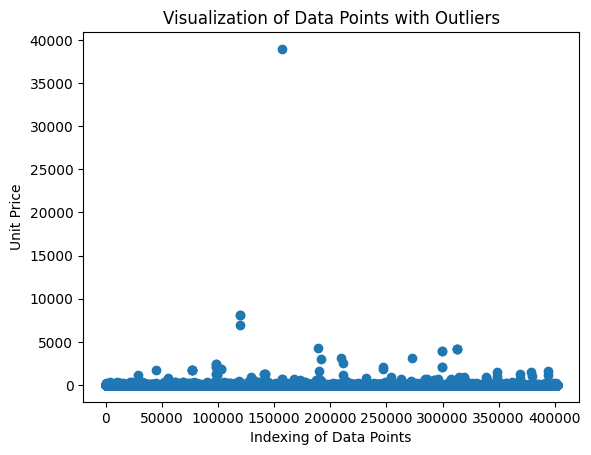

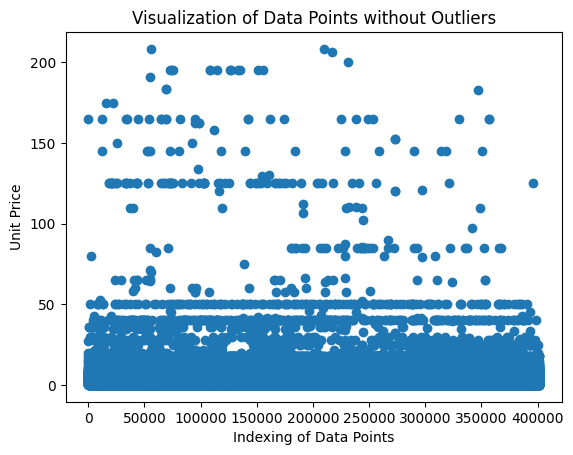

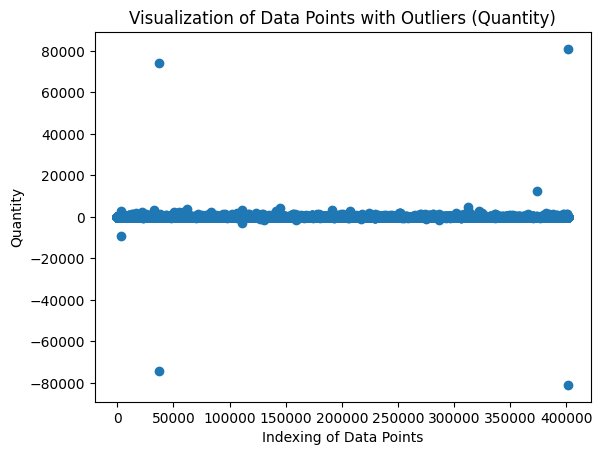

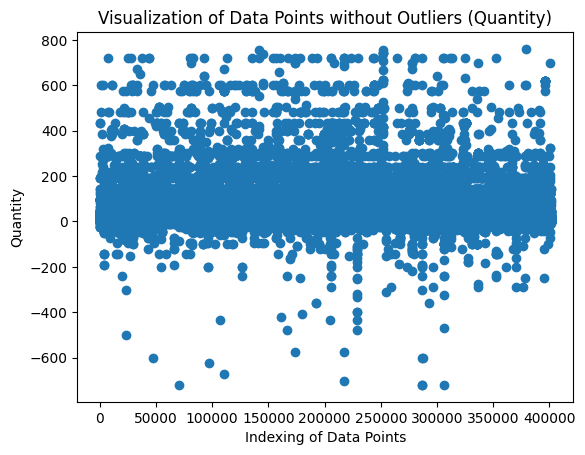

In [ ]:
# Handling Outliers
numeric_columns = ['Quantity', 'UnitPrice', 'CustomerID']

z_scores = stats.zscore(data[numeric_columns])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data_wo_outliers = data[filtered_entries]
print(data_wo_outliers.head())

#Unit Price
plt.scatter(range(len(data)), data['UnitPrice'])
plt.title('Visualization of Data Points with Outliers')
plt.xlabel('Indexing of Data Points')
plt.ylabel('Unit Price')
plt.show()

#Unit Price w/o outliers
plt.scatter(range(len(data_wo_outliers)), data_wo_outliers['UnitPrice'])
plt.title('Visualization of Data Points without Outliers')
plt.xlabel('Indexing of Data Points')
plt.ylabel('Unit Price')
plt.show()

#Quantity
plt.scatter(range(len(data)), data['Quantity'])
plt.title('Visualization of Data Points with Outliers (Quantity)')
plt.xlabel('Indexing of Data Points')
plt.ylabel('Quantity')
plt.show()

#Quantity w/o outliers
plt.scatter(range(len(data_wo_outliers)), data_wo_outliers['Quantity'])
plt.title('Visualization of Data Points without Outliers (Quantity)')
plt.xlabel('Indexing of Data Points')
plt.ylabel('Quantity')
plt.show()

In [ ]:
# Checking the data left after handling duplicates, missing values and outliers
data.shape[0]

401604

In [ ]:
# 2. Feature Engineering
data['TotalPurchase'] = data['Quantity'] * data['UnitPrice']
data['AvgQuantityPerTransaction'] = data.groupby('CustomerID')['Quantity'].transform('mean')
data['TotalInvoices'] = data.groupby('CustomerID')['InvoiceNo'].transform('nunique')
data['UniqueProducts'] = data.groupby('CustomerID')['StockCode'].transform('nunique')
data['TotalAmountSpent'] = data.groupby('CustomerID')['TotalPurchase'].transform('sum')
data['AvgUnitPrice'] = data.groupby('CustomerID')['UnitPrice'].transform('mean')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# RFM Table
max_date = data['InvoiceDate'].max()

# Recency
last_purchase_date = data.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase_date.columns = ['CustomerID', 'LastPurchaseDate']
last_purchase_date['Recency'] = (max_date - last_purchase_date['LastPurchaseDate']).dt.days

# Frequency
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# Monetary
data['TotalPurchase'] = data['Quantity'] * data['UnitPrice']
monetary = data.groupby('CustomerID')['TotalPurchase'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# Merging the RFM features into a single DataFrame
rfm = last_purchase_date.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

# Selecting only CustomerID, Recency, Frequency, and Monetary
rfm_table = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

# Display the new RFM table
print(rfm_table.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


In [ ]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
TotalPurchase,0
AvgQuantityPerTransaction,0


In [ ]:
# 3. Data Preprocessing
# Assuming 'data' is your preprocessed dataset
data_sampled = data.sample(frac=0.1, random_state=42)
data_combined = data_sampled.merge(rfm_table, on='CustomerID', how='left')
features = [
    'Recency',
    'Frequency',
    'Monetary'
]
X_combined = data_combined[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Apply PCA transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


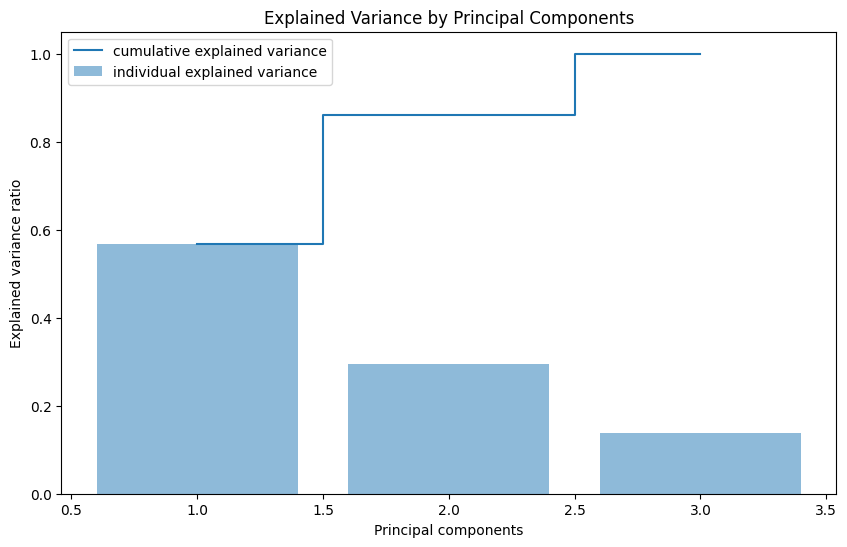

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X_scaled is your scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained by the components
cumulative_variance = explained_variance.cumsum()

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()


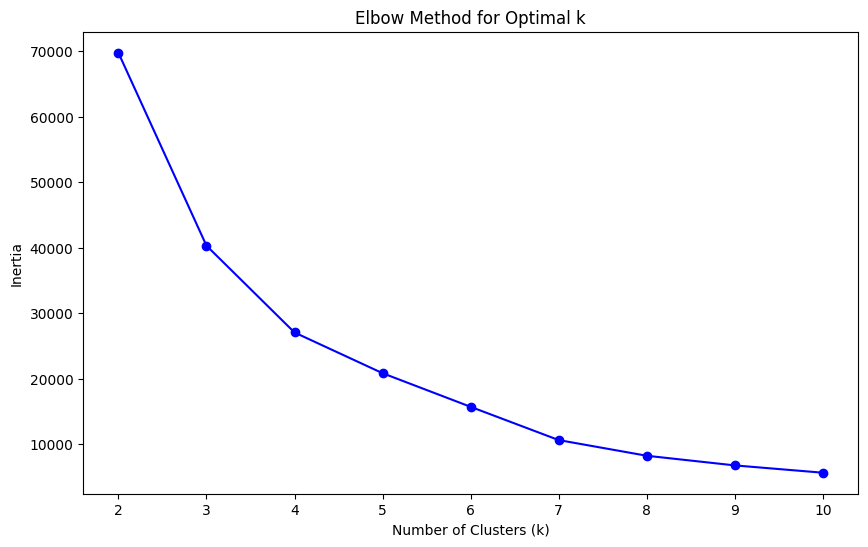

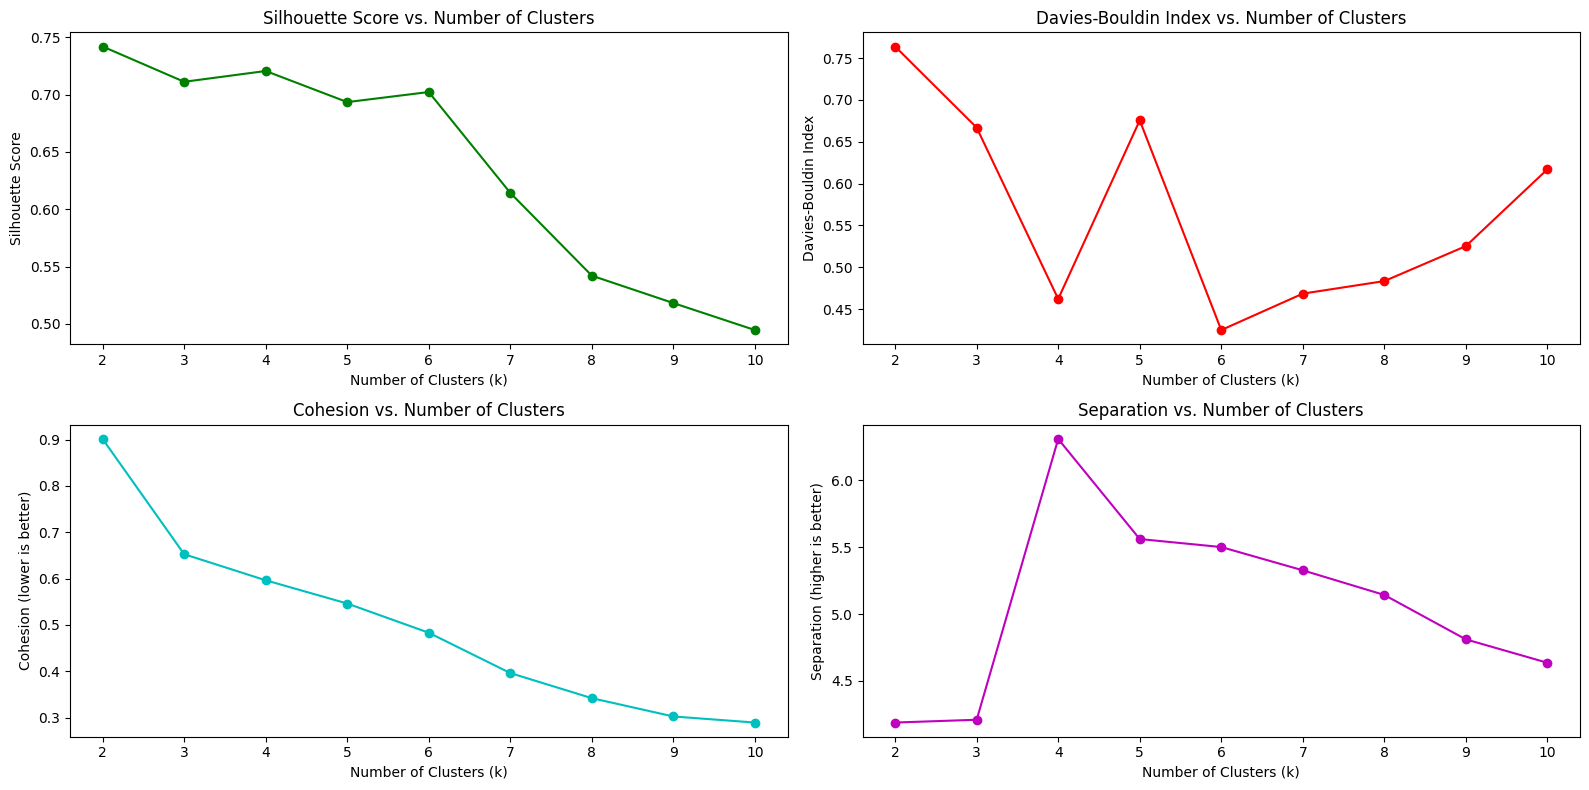

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist

# Define the range of k values to try
k_values = range(2, 11)

# Initialize lists to store the evaluation metrics
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
cohesions = []
separations = []

for k in k_values:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300, init='k-means++')
    clusters = kmeans.fit_predict(X_pca)

    # Calculate inertia (sum of squared distances to centroids)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_pca, clusters)
    silhouette_scores.append(silhouette_avg)

    # Calculate Davies-Bouldin index
    davies_bouldin_avg = davies_bouldin_score(X_pca, clusters)
    davies_bouldin_scores.append(davies_bouldin_avg)

    # Calculate cohesion and separation
    centroids = kmeans.cluster_centers_
    distances = cdist(centroids, centroids, 'euclidean')

    cohesion = np.sum(np.min(cdist(X_pca, centroids, 'euclidean'), axis=1)) / X_pca.shape[0]
    cohesions.append(cohesion)

    separation = np.mean(distances[np.triu_indices(k, 1)])
    separations.append(separation)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot the silhouette score, Davies-Bouldin index, cohesion, and separation for different k
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(k_values, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

plt.subplot(2, 2, 2)
plt.plot(k_values, davies_bouldin_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')

plt.subplot(2, 2, 3)
plt.plot(k_values, cohesions, 'co-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cohesion (lower is better)')
plt.title('Cohesion vs. Number of Clusters')

plt.subplot(2, 2, 4)
plt.plot(k_values, separations, 'mo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Separation (higher is better)')
plt.title('Separation vs. Number of Clusters')

plt.tight_layout()
plt.show()


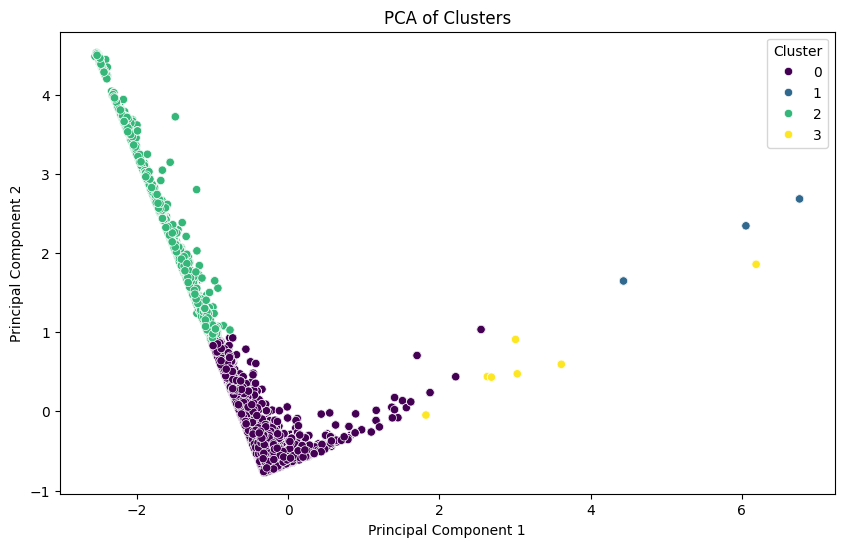

Silhouette Score (should be higher - closer to 1): 0.7205557995674755
Davies-Bouldin Index (should be lower): 0.4620479849743696
Within-cluster Cohesion (lower): 0.5964721915570469
Between-cluster Separation (higher): 6.309828458617467


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Optimal number of clusters is set to 4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300, init='k-means++')
clusters = kmeans.fit_predict(X_pca)
data_combined['Cluster'] = clusters

# Visualize Clusters with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title('PCA of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Evaluate Clustering
silhouette_avg = silhouette_score(X_pca, clusters)
davies_bouldin_avg = davies_bouldin_score(X_pca, clusters)

# Inter-cluster Distance Measures
centroids = kmeans.cluster_centers_
distances = cdist(centroids, centroids, 'euclidean')

cohesion = np.sum(np.min(cdist(X_pca, centroids, 'euclidean'), axis=1)) / X_pca.shape[0]
separation = np.mean(distances[np.triu_indices(optimal_k, 1)])

print(f'Silhouette Score (should be higher - closer to 1): {silhouette_avg}')
print(f'Davies-Bouldin Index (should be lower): {davies_bouldin_avg}')
print(f'Within-cluster Cohesion (lower): {cohesion}')
print(f'Between-cluster Separation (higher): {separation}')


In [ ]:
basket = data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket = basket.map(lambda x: 1 if x > 0 else 0)

print(basket.head())

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                    0                               0   
536366                                    0                               0   
536367                                    0                               0   
536368                                    0                               0   
536369                                    0                               0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                        0                             0   
536366                        0                             0   
536367                        0                             0   
536368                        0                             0   
536369                        0                         

In [ ]:
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

# Convert the binary matrix to a sparse matrix
basket_sparse = csr_matrix(basket)

# Convert the sparse matrix back to a DataFrame to work with mlxtend functions
basket_sparse_df = pd.DataFrame.sparse.from_spmatrix(basket_sparse, index=basket.index, columns=basket.columns)

frequent_itemsets = fpgrowth(basket_sparse_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print(rules.head(10))

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                            antecedents                           consequents  \
0       (ASSORTED COLOUR BIRD ORNAMENT)  (WHITE HANGING HEART T-LIGHT HOLDER)   
1  (WHITE HANGING HEART T-LIGHT HOLDER)       (ASSORTED COLOUR BIRD ORNAMENT)   
2            (REGENCY CAKESTAND 3 TIER)       (ASSORTED COLOUR BIRD ORNAMENT)   
3       (ASSORTED COLOUR BIRD ORNAMENT)            (REGENCY CAKESTAND 3 TIER)   
4            (LOVE BUILDING BLOCK WORD)            (HOME BUILDING BLOCK WORD)   
5            (HOME BUILDING BLOCK WORD)            (LOVE BUILDING BLOCK WORD)   
6          (POPPY'S PLAYHOUSE BEDROOM )           (POPPY'S PLAYHOUSE KITCHEN)   
7           (POPPY'S PLAYHOUSE KITCHEN)          (POPPY'S PLAYHOUSE BEDROOM )   
8            (JAM MAKING SET WITH JARS)   (SET OF 3 CAKE TINS PANTRY DESIGN )   
9   (SET OF 3 CAKE TINS PANTRY DESIGN )            (JAM MAKING SET WITH JARS)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.061965         

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import association_rules, fpgrowth

def market_basket_analysis_for_cluster(cluster_data, min_support=0.001):
    # Consider limiting to top N products to reduce memory usage
    top_n_products = 100  # Adjust this number based on memory limitations
    top_products = cluster_data['Description'].value_counts().nlargest(top_n_products).index
    cluster_data = cluster_data[cluster_data['Description'].isin(top_products)]

    # Create the basket matrix
    basket = cluster_data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

    # Convert quantities to binary (purchased or not)
    basket = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Convert to sparse matrix format
    basket_sparse = csr_matrix(basket)
    basket_sparse_df = pd.DataFrame.sparse.from_spmatrix(basket_sparse, index=basket.index, columns=basket.columns)
    basket_sparse_df = basket_sparse_df.astype(bool)

    # Run the fpgrowth algorithm
    frequent_itemsets = fpgrowth(basket_sparse_df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    return rules

for cluster_label in data_combined['Cluster'].unique():
    print(f"Market Basket Analysis for Cluster {cluster_label}")

    cluster_data = data_combined[data_combined['Cluster'] == cluster_label]

    # Set an even lower min_support for Clusters 0 and 3
    if cluster_label in [0, 3]:
        min_support = 0.0005  # Lowering the threshold more aggressively
    else:
        min_support = 0.002  # Set for Clusters 1 and 2

    # Process in chunks if data size is too large
    cluster_rules = market_basket_analysis_for_cluster(cluster_data, min_support=min_support)

    if not cluster_rules.empty:
        print(cluster_rules.head(10))
    else:
        print("No rules found for this cluster with the current min_support.")
    print("\n")


Market Basket Analysis for Cluster 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


                            antecedents                           consequents  \
0  (WHITE HANGING HEART T-LIGHT HOLDER)    (RED HANGING HEART T-LIGHT HOLDER)   
1    (RED HANGING HEART T-LIGHT HOLDER)  (WHITE HANGING HEART T-LIGHT HOLDER)   
2      (JUMBO  BAG BAROQUE BLACK WHITE)             (JUMBO BAG RED RETROSPOT)   
3             (JUMBO BAG RED RETROSPOT)      (JUMBO  BAG BAROQUE BLACK WHITE)   
4             (JUMBO BAG PINK POLKADOT)      (JUMBO  BAG BAROQUE BLACK WHITE)   
5      (JUMBO  BAG BAROQUE BLACK WHITE)             (JUMBO BAG PINK POLKADOT)   
6                  (JUMBO BAG ALPHABET)      (JUMBO  BAG BAROQUE BLACK WHITE)   
7      (JUMBO  BAG BAROQUE BLACK WHITE)                  (JUMBO BAG ALPHABET)   
8            (LUNCH BAG VINTAGE DOILY )      (JUMBO  BAG BAROQUE BLACK WHITE)   
9      (JUMBO  BAG BAROQUE BLACK WHITE)            (LUNCH BAG VINTAGE DOILY )   

   antecedent support  consequent support   support  confidence      lift  \
0            0.037651          

<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


                           antecedents                          consequents  \
0  (RETROSPOT PARTY BAG + STICKER SET)    (CLOTHES PEGS RETROSPOT PACK 24 )   
1    (CLOTHES PEGS RETROSPOT PACK 24 )  (RETROSPOT PARTY BAG + STICKER SET)   
2  (RETROSPOT PARTY BAG + STICKER SET)   (WOODLAND PARTY BAG + STICKER SET)   
3   (WOODLAND PARTY BAG + STICKER SET)  (RETROSPOT PARTY BAG + STICKER SET)   
4                  (GUMBALL COAT RACK)     (CREAM CUPID HEARTS COAT HANGER)   
5     (CREAM CUPID HEARTS COAT HANGER)                  (GUMBALL COAT RACK)   
6             (JAM MAKING SET PRINTED)   (PLASTERS IN TIN VINTAGE PAISLEY )   
7   (PLASTERS IN TIN VINTAGE PAISLEY )             (JAM MAKING SET PRINTED)   
8             (JAM MAKING SET PRINTED)    (60 CAKE CASES DOLLY GIRL DESIGN)   
9    (60 CAKE CASES DOLLY GIRL DESIGN)             (JAM MAKING SET PRINTED)   

   antecedent support  consequent support   support  confidence   lift  \
0            0.025974            0.025974  0.012987     

In [ ]:
import pandas as pd

# Function to create a summary table for top 3 products
def create_top_3_table(cluster_rules):
    # Sort by lift, confidence, and support, then select the top 3 for each
    top_lift = cluster_rules.nlargest(3, 'lift')
    top_confidence = cluster_rules.nlargest(3, 'confidence')
    top_support = cluster_rules.nlargest(3, 'support')

    # Combine into a single DataFrame with clear labels
    top_3_table = pd.concat([
        top_lift.assign(Ranking='Top Lift'),
        top_confidence.assign(Ranking='Top Confidence'),
        top_support.assign(Ranking='Top Support')
    ])

    # Reset index for better display
    top_3_table.reset_index(drop=True, inplace=True)
    return top_3_table[['Ranking', 'antecedents', 'consequents', 'lift', 'confidence', 'support']]

# Iterate over each cluster
for cluster_label in data_combined['Cluster'].unique():
    print(f"Top 3 Products for Cluster {cluster_label}")

    cluster_data = data_combined[data_combined['Cluster'] == cluster_label]

    # For Clusters 0 and 3, reduce the min_support further
    if cluster_label in [0, 3]:
        min_support = 0.0001  # Lowering support aggressively
    else:
        min_support = 0.002  # Standard min_support for other clusters

    cluster_rules = market_basket_analysis_for_cluster(cluster_data, min_support=min_support)

    if not cluster_rules.empty:
        top_3_table = create_top_3_table(cluster_rules)
        print(top_3_table)
        top_3_table.to_excel('top_3_products.xlsx', index=True)
    else:
        print("No significant rules found for this cluster.")
    print("\n")
    top_3_table.to_excel('top_3_products.xlsx', index=True)


Top 3 Products for Cluster 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


          Ranking                                        antecedents  \
0        Top Lift        (LUNCH BAG RED RETROSPOT, JUMBO BAG APPLES)   
1        Top Lift  (LUNCH BAG SPACEBOY DESIGN , JUMBO  BAG BAROQU...   
2        Top Lift                (PARTY BUNTING, JUMBO BAG ALPHABET)   
3  Top Confidence  (WHITE HANGING HEART T-LIGHT HOLDER, ALARM CLO...   
4  Top Confidence  (RED HANGING HEART T-LIGHT HOLDER, ALARM CLOCK...   
5  Top Confidence  (ALARM CLOCK BAKELIKE PINK, JUMBO  BAG BAROQUE...   
6     Top Support                        (ALARM CLOCK BAKELIKE RED )   
7     Top Support                       (ALARM CLOCK BAKELIKE GREEN)   
8     Top Support                           (LUNCH BAG APPLE DESIGN)   

                                         consequents         lift  confidence  \
0  (LUNCH BAG SPACEBOY DESIGN , JUMBO  BAG BAROQU...  4887.000000    1.000000   
1        (LUNCH BAG RED RETROSPOT, JUMBO BAG APPLES)  4887.000000    1.000000   
2  (JUMBO  BAG BAROQUE BLACK WHITE, 

<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


          Ranking                           antecedents  \
0        Top Lift          (LUNCH BAG SPACEBOY DESIGN )   
1        Top Lift              (JUMBO STORAGE BAG SUKI)   
2        Top Lift    (HANGING HEART JAR T-LIGHT HOLDER)   
3  Top Confidence    (HANGING HEART JAR T-LIGHT HOLDER)   
4  Top Confidence     (GREEN REGENCY TEACUP AND SAUCER)   
5  Top Confidence  (VINTAGE HEADS AND TAILS CARD GAME )   
6     Top Support     (GREEN REGENCY TEACUP AND SAUCER)   
7     Top Support  (WHITE HANGING HEART T-LIGHT HOLDER)   
8     Top Support            (RED RETROSPOT CAKE STAND)   

                            consequents       lift  confidence   support  
0              (JUMBO STORAGE BAG SUKI)  20.281250    0.250000  0.003082  
1          (LUNCH BAG SPACEBOY DESIGN )  20.281250    0.250000  0.003082  
2               (HEART OF WICKER SMALL)  19.666667    0.333333  0.003082  
3               (HEART OF WICKER SMALL)  19.666667    0.333333  0.003082  
4  (WHITE HANGING HEART T-LIGHT HO

<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [ ]:
import pandas as pd

# Create a list to store top 3 tables for each cluster
top_3_tables = []

# Function to create a summary table for top 3 products
def create_top_3_table(cluster_rules):
    top_lift = cluster_rules.nlargest(3, 'lift')
    top_confidence = cluster_rules.nlargest(3, 'confidence')
    top_support = cluster_rules.nlargest(3, 'support')

    top_3_table = pd.concat([
        top_lift.assign(Ranking='Top Lift'),
        top_confidence.assign(Ranking='Top Confidence'),
        top_support.assign(Ranking='Top Support')
    ])

    top_3_table.reset_index(drop=True, inplace=True)
    return top_3_table[['Ranking', 'antecedents', 'consequents', 'lift', 'confidence', 'support']]

# Iterate over each cluster
for cluster_label in data_combined['Cluster'].unique():
    cluster_data = data_combined[data_combined['Cluster'] == cluster_label]

    # Adjust min_support
    min_support = 0.0001 if cluster_label in [0, 3] else 0.002

    cluster_rules = market_basket_analysis_for_cluster(cluster_data, min_support=min_support)

    if not cluster_rules.empty:
        top_3_table = create_top_3_table(cluster_rules)
        top_3_table['Cluster'] = cluster_label  # Add a column to indicate the cluster
        top_3_tables.append(top_3_table)
    else:
        print(f"No significant rules found for Cluster {cluster_label}.")
# Combine all top 3 tables into a single DataFrame
combined_top_3 = pd.concat(top_3_tables, ignore_index=True)

# Optional: Reorder columns if desired
combined_top_3 = combined_top_3[['Cluster', 'Ranking', 'antecedents', 'consequents', 'lift', 'confidence', 'support']]
# Export the combined DataFrame to an Excel file
combined_top_3.to_excel('top_3_products_per_cluster.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-16-2b4fbd92713d>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bas

In [ ]:
cluster_summary = data_combined.groupby('Cluster').agg(
    avg_sales_cust=('Monetary', 'mean'),
    avg_sales_inv=('Monetary', lambda x: x.sum() / x.count()),  # Total Monetary / Number of Invoices
    avg_recency=('Recency', 'mean'),
    avg_frequency=('Frequency', 'mean'),
    total_invoices=('InvoiceNo', 'nunique'),  # Count of unique invoices per cluster
    num_customers=('CustomerID', 'nunique')  # Count of unique customers per cluster
).reset_index()

# Calculate the average number of invoices per customer
cluster_summary['avg_invoices_per_customer'] = cluster_summary['total_invoices'] / cluster_summary['num_customers']
cluster_summary['avg_sales_per_customer'] = cluster_summary['avg_sales_cust']/cluster_summary['num_customers']
cluster_summary['avg_sales_per_invoice'] = cluster_summary['avg_sales_inv']/cluster_summary['total_invoices']

# Drop the 'total_invoices' column if it's no longer needed
# cluster_summary = cluster_summary.drop(columns=['total_invoices'])

print(cluster_summary)


   Cluster  avg_sales_cust  avg_sales_inv  avg_recency  avg_frequency  \
0        0     5901.829324    5901.829324    22.727427      12.633944   
1        1   265028.686477  265028.686477     1.580537      72.177852   
2        2      991.639228     991.639228   212.661196       3.218370   
3        3    60802.957833   60802.957833     0.864202     176.176654   

   total_invoices  num_customers  avg_invoices_per_customer  \
0           11328           2867                   3.951168   
1             103              3                  34.333333   
2            1431            946                   1.512685   
3             698              7                  99.714286   

   avg_sales_per_customer  avg_sales_per_invoice  
0                2.058538               0.520995  
1            88342.895492            2573.094043  
2                1.048244               0.692969  
3             8686.136833              87.110255  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd

# Function to create a summary table for top 3 products by total quantity sold
def create_top_3_table(cluster_data):
    # Calculate total quantity sold for each product
    product_summary = cluster_data.groupby('Description')['Quantity'].sum().reset_index()

    # Sort by quantity sold and select the top 3
    top_3_table = product_summary.nlargest(3, 'Quantity')

    # Add a ranking column
    top_3_table['Ranking'] = ['Top 1', 'Top 2', 'Top 3']

    return top_3_table[['Ranking', 'Description', 'Quantity']]

# Iterate over each cluster and display the top 3 products
for cluster_label in data_combined['Cluster'].unique():
    print(f"Top 3 Products for Cluster {cluster_label + 1}")  # Adding 1 to change from 0, 1, 2 to 1, 2, 3

    cluster_data = data_combined[data_combined['Cluster'] == cluster_label]

    # Generate the top 3 products table
    top_3_table = create_top_3_table(cluster_data)
    print(top_3_table)  # Print to console
    print("\n")


Top 3 Products for Cluster 1
     Ranking                         Description  Quantity
195    Top 1      ASSTD DESIGN 3D PAPER STICKERS     12540
1162   Top 2  GROW A FLYTRAP OR SUNFLOWER IN TIN      3936
1743   Top 3     PACK OF 72 RETROSPOT CAKE CASES      3332


Top 3 Products for Cluster 4
     Ranking                      Description  Quantity
1245   Top 1             WRAP ALPHABET DESIGN       600
1257   Top 2  YOU'RE CONFUSING ME METAL SIGN        445
252    Top 3       COOK WITH WINE METAL SIGN        410


Top 3 Products for Cluster 3
     Ranking                     Description  Quantity
552    Top 1     GIN + TONIC DIET METAL SIGN      2034
99     Top 2       ASSORTED COLOURS SILK FAN      1956
1309   Top 3  SMALL CERAMIC TOP STORAGE JAR       1380


Top 3 Products for Cluster 2
    Ranking                          Description  Quantity
189   Top 1  SET OF TEA COFFEE SUGAR TINS PANTRY      1436
16    Top 2              BLACK HEART CARD HOLDER      1152
223   Top 3   WHITE H

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
